In [1]:
# Standard imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('seaborn-white')
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18

#FITS
from astropy.io import fits

# Image processing
import cv2
from skimage.feature import shape_index
from scipy import ndimage as ndi

# Indentification des sites dans une image peu encombree

In [2]:
img = fits.getdata("jour0_01.fits")
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

In [4]:
zoom_img  = img[1050:1350,1150:1450]#  zone avec un bloc encombre img[150:400,850:1050]
zoom_img_r = np.invert(zoom_img)

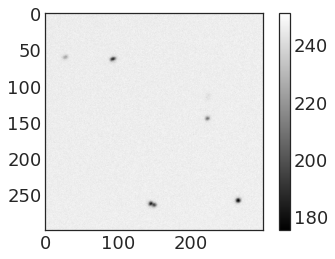

In [5]:
plt.imshow(zoom_img_r,cmap='gray')
plt.colorbar()

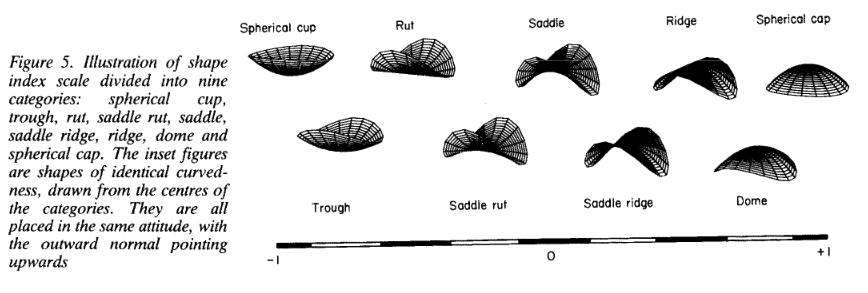

In [6]:
s = shape_index(zoom_img,mode='reflect')

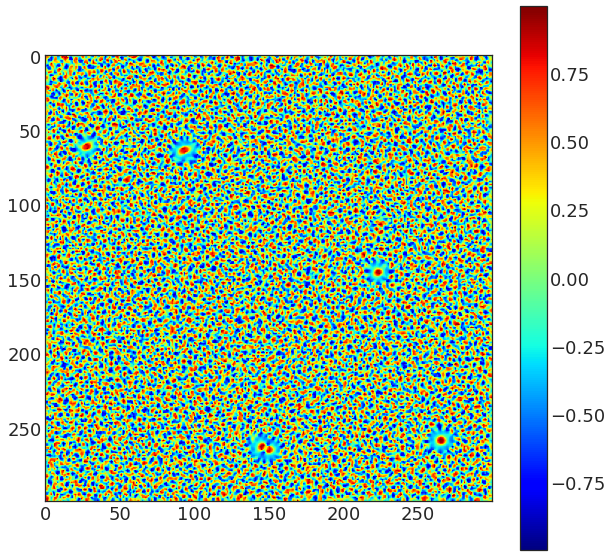

In [7]:
fig, ax= plt.subplots(figsize=(10,10))
plt.imshow(s)
plt.colorbar()

**Il faut enleve le bruit par un filtrage gaussien**

In [8]:
s_smooth = ndi.gaussian_filter(s, sigma=1.5)

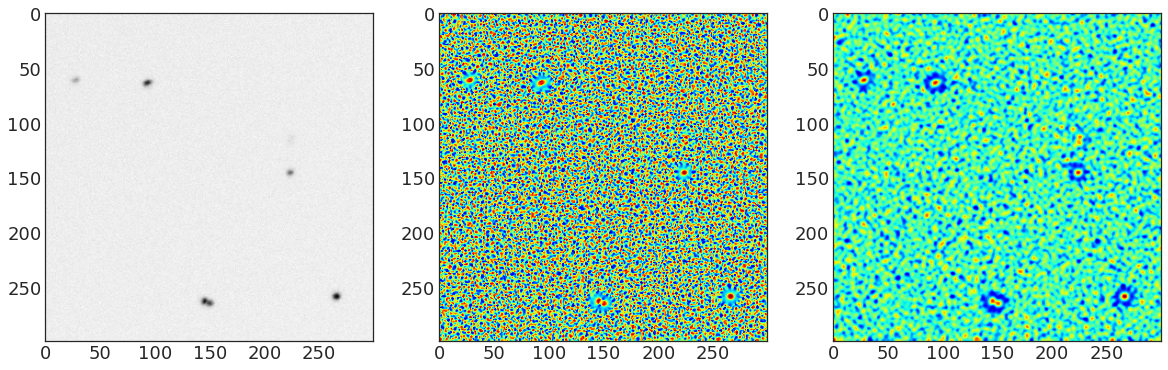

In [9]:
fig,axs=plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(zoom_img_r,cmap="gray")
axs[1].imshow(s)
axs[2].imshow(s_smooth)
#plt.colorbar()

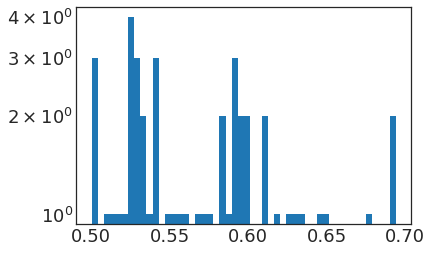

In [10]:
plt.hist((s_smooth[s_smooth>0.5]).flatten(),bins=50)
plt.yscale("log")

**Trouver les pixels dont la shape la plus adaptiée est celle d'une spherical cap**

In [23]:
target = 0.65
delta = 0.25
point_y_s, point_x_s = np.where(np.abs(s_smooth - target) < delta)
#point_z_s = zoom_img_r[point_y_s, point_x_s]

new_img = np.zeros_like(zoom_img_r)
new_img[point_y_s, point_x_s]=zoom_img_r[point_y_s, point_x_s]

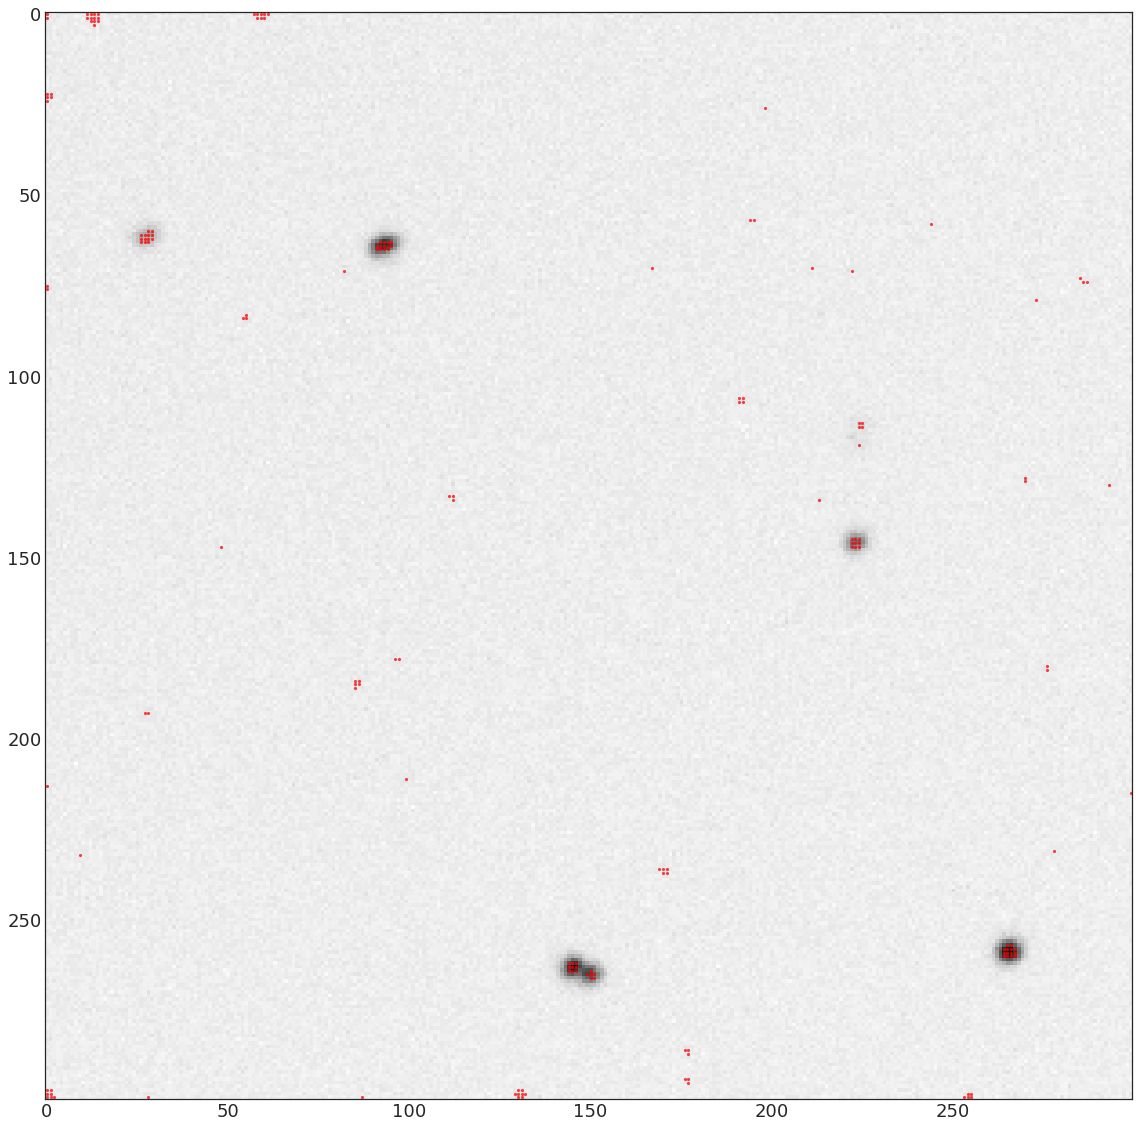

In [24]:
fig, ax= plt.subplots(figsize=(20,20))
g0=ax.imshow(zoom_img_r,cmap="gray")
scatter_settings = dict(alpha=0.75, s=10, linewidths=0)
ax.scatter(point_x_s, point_y_s, color='red', **scatter_settings)

**Agglomerer les "blobs" pour en obtenir, le centroid et le diametre equivalent**

In [25]:
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = False
#params.minArea = 5
#params.maxArea = 50

params.filterByInertia = False
params.filterByConvexity = False
params.filterByCircularity=False
params.filterByColor=False
params.minThreshold = 0;
params.maxThreshold = 255;
# Distance Between Blobs
params.minDistBetweenBlobs = 0

detector = cv2.SimpleBlobDetector_create(params)

In [26]:
keypoints = detector.detect(new_img)

In [27]:
x_centroids = []
y_centroids = []
s_blobs = []
for keyPoint in keypoints:
    x_centroids.append(keyPoint.pt[0])
    y_centroids.append(keyPoint.pt[1])
    s_blobs.append(keyPoint.size)

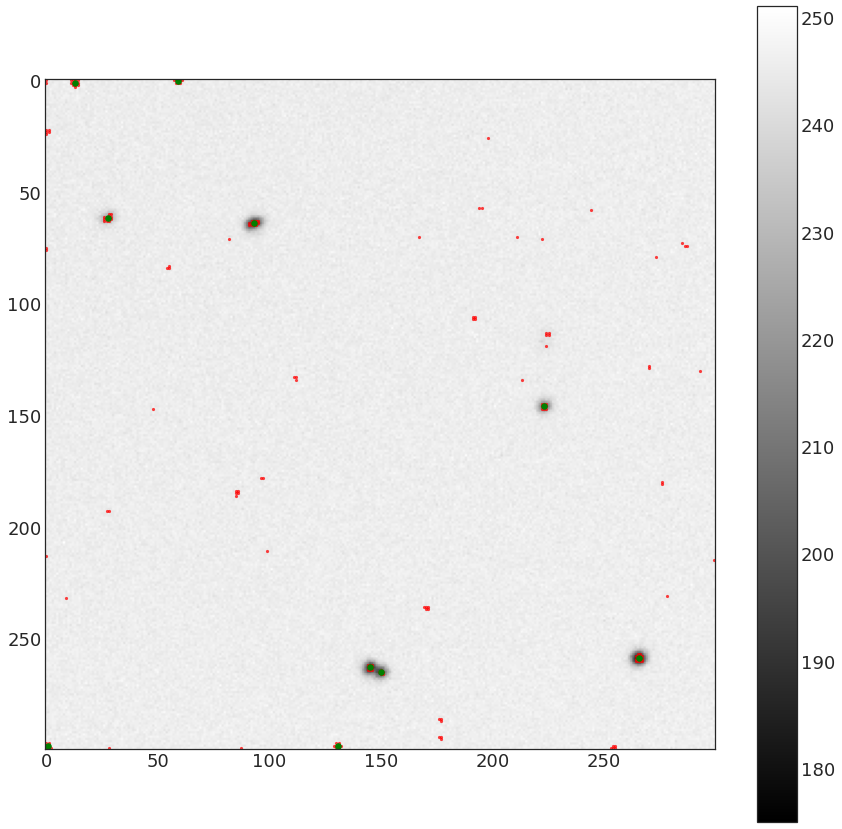

In [28]:
im_with_keypoints = cv2.drawKeypoints(new_img, keypoints, np.array([]), 
                                      (0,0,255), 
                                      cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)# Show keypoints
fig, ax= plt.subplots(figsize=(15,15))
g0=ax.imshow(zoom_img_r,cmap="gray")
ax.scatter(point_x_s, point_y_s, color='red', **scatter_settings)
for x,y,s in zip(x_centroids,y_centroids,s_blobs):
    if s < 2: continue
    ax.scatter(x,y,c='green',s=30)
    r = s/2 # size is the diameter
#    circle = plt.Circle((x, y), r, color="blue", linewidth=2, fill=False)
    #plt.imshow(im_with_keypoints,cmap="gray")
#    ax.add_patch(circle)
plt.colorbar(g0);